In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import getcwd
import numpy as np
import os
import sys

In [3]:
home_path = os.path.join(getcwd(), '..', '..', '..')
general_data_path = os.path.join(home_path, 'seaa-energy', 'integrate-data','data')
project_data_path = os.path.join(getcwd(), '..', 'data')
sys.path.append(os.path.join(home_path, 'helpers'))
import visualization as viz

In [4]:
# LOAD LOAD DATA
df_load = pd.read_pickle(os.path.join(general_data_path, 'df_load.pkl'), compression='gzip')
df_load = df_load['SE_3'].rename('load').to_frame()
df_load = df_load.replace(0, np.nan).ffill()

# LOAD TEMP DATA, ONLY DAILY, TODO: ADD HOURLY DATA
# https://bolin.su.se/data/stockholm-historical-daily-temperature-2?n=stockholm-historical-temps-daily-2
df_temp = pd.read_csv(os.path.join(project_data_path, 'stockholm_daily_mean_temperature.csv'))
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp = df_temp.set_index('date').sort_index()
df_temp.loc[df_temp['raw'] == -999, 'raw'] = np.nan # 999 Code for missing values
df_temp.max()

raw       28.3
homo      27.5
adjust    27.5
site       3.0
dtype: float64

Text(0, 0.5, 'temperature [$^\\circ$C]')

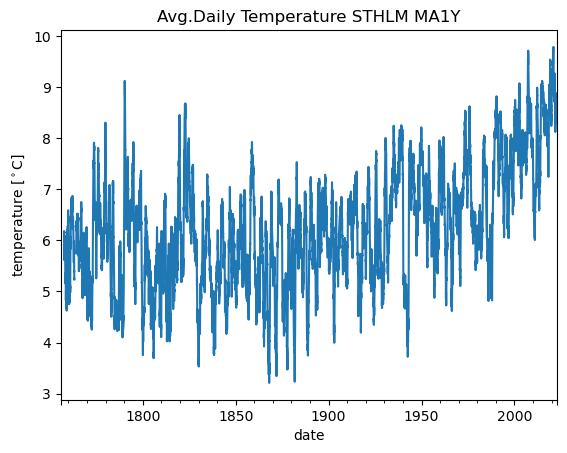

In [5]:
ax = df_temp['raw'].rolling(365).mean().plot(title = 'Avg.Daily Temperature STHLM MA1Y')
ax.set_ylabel('temperature [$^\circ$C]')

In [6]:
# MERGE DATA
df_data = df_load.merge(df_temp['raw'].rename('temp'), how = 'left', left_index = True, right_index = True)
df_data = df_data.ffill()


daily = True
if daily:
    df_data = df_data.resample('D').mean()

df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2014-12-13 to 2022-12-12
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    2922 non-null   float64
 1   temp    2922 non-null   float64
dtypes: float64(2)
memory usage: 68.5 KB


<AxesSubplot:>

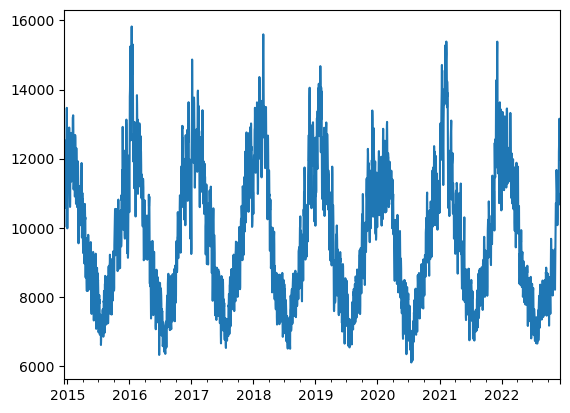

In [7]:
df_data['load'].plot()

In [8]:
import datetime
df_data_train = df_data[df_data.index < '2022-01-01'].copy()
df_data_test = df_data[df_data.index >= '2022-01-01'].copy()

In [11]:
df_data_train['load_inv'] = 1/df_data_train['load']


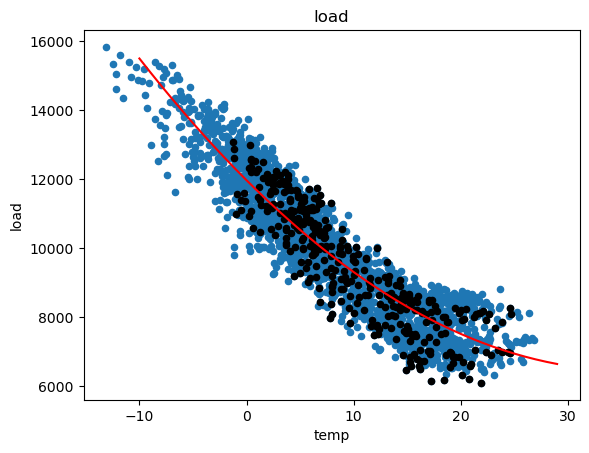

In [77]:
df_data_train['load_log'] = df_data_train['load'].apply(np.log)
df_data_test['load_log'] = df_data_test['load'].apply(np.log)


x = np.arange(-10, 30)
fit = np.polyfit(df_data_train['temp'], df_data_train['load'], deg=2)
p = np.poly1d(fit)
y = p(x)


ax = df_data_train.plot(kind='scatter', x='temp', y='load', title = f"load")
ax = df_data_train[df_data_train.index.year == 2020].plot(ax = ax, kind='scatter', x='temp', y='load', title = f"load",  color='black')
#df_data_test.plot(ax=ax,kind='scatter', x='temp', y='load', color='black', edgecolor= 'black')
#df_data_train['count'] = range(df_data_train.shape[0])

plt.plot(x, y, color='red')


y = p(x)

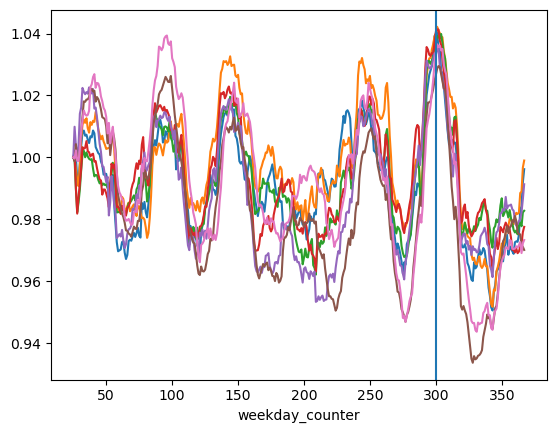

In [74]:
df_data_train['load_temp'] = p(df_data_train['temp'])
df_data_train['load_temp_adj'] = df_data_train['load_temp'].div(df_data_train['load'])

df_data_train['weekday'] = pd.to_datetime(df_data_train.index).weekday
df_data_train['load_pct_deviation'] = df_data_train['load_temp_adj'].div(df_data_train['load_temp_adj'].rolling(7, min_periods = 6).mean())
weekday_scale = df_data_train.groupby('weekday')['load_pct_deviation'].mean().rename('weekday_scale')

df_data_train['weekday_counter'] = df_data_train.groupby('weekday')['load_pct_deviation'].cumcount()


df_weekday_trend = df_data_train.pivot(index = 'weekday_counter', columns = 'weekday', values = 'load_temp_adj').dropna().rolling(26).mean().dropna()

ax = df_weekday_trend.div(df_weekday_trend.iloc[0]).plot(legend=False)
ax.axvline(300)


In [73]:
df_data_train[df_data_train['weekday_counter']==300]

,load,temp,load_log,load_inv,weekday,load_pct_deviation,weekday_counter,load_temp,load_temp_adj
2020-09-12,7792.583333,12.9,8.960928,0.000128,5,1.079485,300,8704.057869,1.116967
2020-09-13,7683.416667,13.5,8.946820,0.000130,6,1.085183,300,8587.282898,1.117639
2020-09-14,8510.791667,15.7,9.049090,0.000117,0,0.937485,300,8185.769407,0.961811
2020-09-15,8662.250000,15.2,9.066730,0.000115,1,0.934269,300,8273.343546,0.955103
2020-09-16,8711.375000,13.5,9.072385,0.000115,2,0.963793,300,8587.282898,0.985755
2020-09-17,8948.750000,10.4,9.099269,0.000112,3,1.006033,300,9224.163410,1.030777
2020-09-18,8639.500000,13.1,9.064100,0.000116,4,0.979014,300,8664.786627,1.002927


In [54]:
df_data_test['pred'] = p(df_data_test['temp'])

df_data_test['weekday'] = df_data_test.index.weekday
df_data_test = df_data_test.merge(weekday_scale, right_index = True, left_on='weekday').sort_index()
df_data_test

,load,temp,pred,weekday,weekday_scale
2022-01-01,10829.083333,-0.7,12186.809494,5,0.926387
2022-01-02,10549.833333,2.6,11194.616246,6,0.924540
2022-01-03,11225.375000,4.3,10720.275663,0,1.034447
2022-01-04,11979.333333,1.3,11574.227063,1,1.034777
2022-01-05,12613.375000,-1.5,12441.537522,2,1.039623
...,...,...,...,...,...
2022-12-08,13156.083333,-1.0,12281.683282,3,1.032867
2022-12-09,12688.333333,-1.0,12281.683282,4,1.009563
2022-12-10,11984.750000,-1.0,12281.683282,5,0.926387
2022-12-11,12417.208333,-1.0,12281.683282,6,0.924540


In [55]:
df_data_test['pred_weekday'] = df_data_test['pred'].mul(df_data_test['weekday_scale'])
df_data_test

,load,temp,pred,weekday,weekday_scale,pred_weekday
2022-01-01,10829.083333,-0.7,12186.809494,5,0.926387,11289.702372
2022-01-02,10549.833333,2.6,11194.616246,6,0.924540,10349.868198
2022-01-03,11225.375000,4.3,10720.275663,0,1.034447,11089.560552
2022-01-04,11979.333333,1.3,11574.227063,1,1.034777,11976.740569
2022-01-05,12613.375000,-1.5,12441.537522,2,1.039623,12934.506280
...,...,...,...,...,...,...
2022-12-08,13156.083333,-1.0,12281.683282,3,1.032867,12685.341641
2022-12-09,12688.333333,-1.0,12281.683282,4,1.009563,12399.128191
2022-12-10,11984.750000,-1.0,12281.683282,5,0.926387,11377.592219
2022-12-11,12417.208333,-1.0,12281.683282,6,0.924540,11354.904932


In [60]:
df_data_train['pred'] = p(df_data_train['temp'])
df_data_train

,load,temp,weekday,load_pct_deviation,pred
2014-12-13,10826.041667,1.7,5,NaN,11455.865601
2014-12-14,10027.000000,1.6,6,NaN,11485.326122
2014-12-15,11582.250000,4.0,0,NaN,10802.165002
2014-12-16,12045.541667,1.8,1,NaN,11426.491643
2014-12-17,12530.333333,0.5,2,NaN,11815.105012
...,...,...,...,...,...
2021-12-27,13428.458333,-4.0,0,1.030080,13273.269844
2021-12-28,12995.541667,0.0,1,1.002833,11968.467027
2021-12-29,12509.458333,0.6,2,0.977406,11784.692298
2021-12-30,11661.625000,2.6,3,0.921080,11194.616246


<AxesSubplot:>

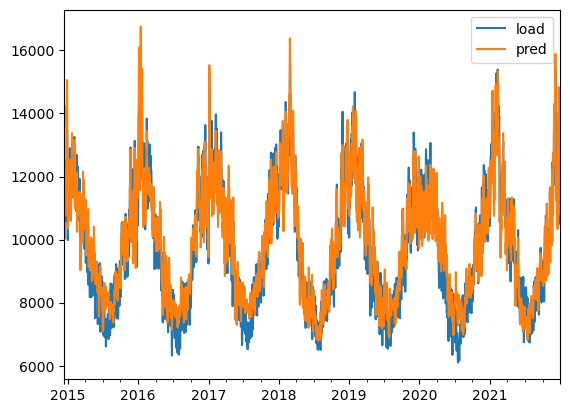

In [65]:
df_data_train[['load', 'pred']].rolling(1).mean().plot()

<AxesSubplot:>

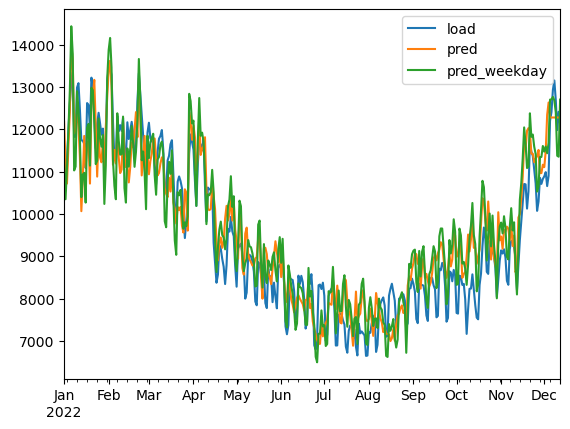

In [59]:
df_data_test[['load', 'pred', 'pred_weekday']].plot()

## PROPHET

In [53]:
from prophet import Prophet

In [54]:
df_data_train_prophet = df_data_train[['load', 'temp']].reset_index().rename(columns = {'index':'ds','load':'y'})
df_data_test_prophet = df_data_test[['load', 'temp']].reset_index().rename(columns = {'index':'ds','load':'y'})

df_data_test_prophet

,ds,y,temp
0,2022-01-01,10829.083333,-0.7
1,2022-01-02,10549.833333,2.6
2,2022-01-03,11225.375000,4.3
3,2022-01-04,11979.333333,1.3
4,2022-01-05,12613.375000,-1.5
...,...,...,...
341,2022-12-08,13156.083333,-1.0
342,2022-12-09,12688.333333,-1.0
343,2022-12-10,11984.750000,-1.0
344,2022-12-11,12417.208333,-1.0


In [55]:
m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor('temp')
m.fit(df_data_train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\ohjartarson\Anaconda3\envs\prophet\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [56]:
future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(df_data_test_prophet)

C:\Users\ohjartarson\Anaconda3\envs\prophet\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\ohjartarson\Anaconda3\envs\prophet\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [35]:
forecast[['ds', 'yhat']]

,ds,yhat
0,2022-01-01,11480.114059
1,2022-01-02,10985.574397
2,2022-01-03,11848.025246
3,2022-01-04,12386.859118
4,2022-01-05,12962.346257
...,...,...
324,2022-11-21,12812.077003
325,2022-11-22,12597.619200
326,2022-11-23,12733.707977
327,2022-11-24,12641.468500


<AxesSubplot:>

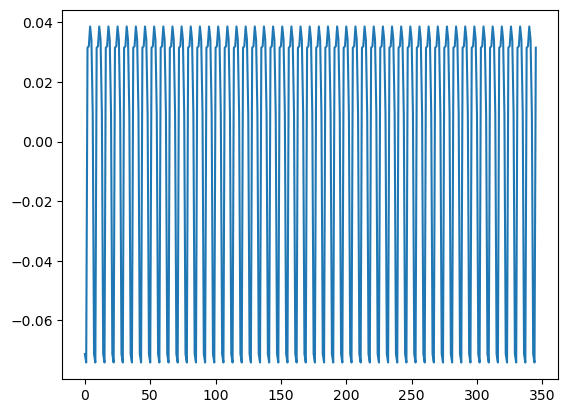

In [60]:
forecast['weekly'].plot()

In [40]:
df_data_test_prophet['ds'] = pd.to_datetime(df_data_test_prophet['ds'])
df_data_test_prophet.info()
df_data_test.info()# = df_data_test.merge(forecast[['ds', 'yhat']], right_on = 'ds', left_index=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 0 to 328
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      329 non-null    datetime64[ns]
 1   y       329 non-null    float64       
 2   temp    329 non-null    float64       
 3   yhat    329 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 12.9 KB
<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 2022-01-01 to 2022-11-25
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   load           329 non-null    float64
 1   temp           329 non-null    float64
 2   pred           329 non-null    float64
 3   weekday        329 non-null    int64  
 4   weekday_scale  329 non-null    float64
 5   pred_weekday   329 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 18.0+ KB


yhat    730.363679
pred    215.936189
dtype: float64

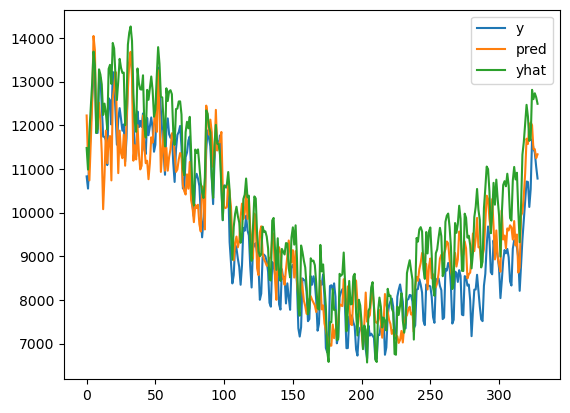

In [16]:
df_data_test_prophet = df_data_test_prophet.dropna()#.set_index('ds')
accuracy = df_data_test_prophet[['yhat', 'pred', 'pred_weekday']].sub(df_data_test_prophet['y'], axis=0).mean()
df_data_test_prophet[['y','pred','yhat', 'pred_weekday']].plot()
accuracy

yhat    739.397896
pred    215.936189
dtype: float64

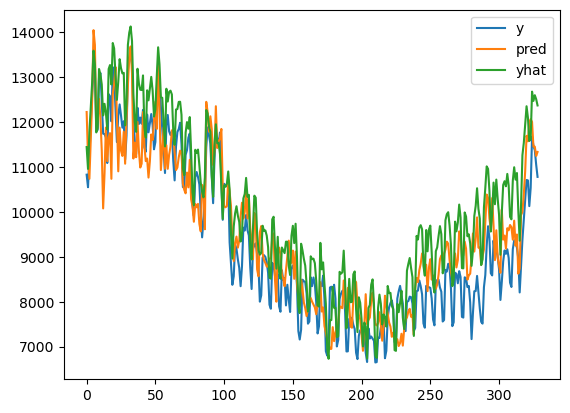

In [17]:
df_data_test_prophet = df_data_test_prophet.dropna()#.set_index('ds')
accuracy = df_data_test_prophet[['yhat', 'pred']].sub(df_data_test_prophet['y'], axis=0).mean()
df_data_test_prophet[['y','pred','yhat']].plot()
accuracy